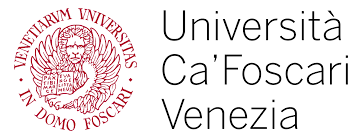

 

<center><h1> ARTIFICIAL INTELLIGENCE: KNOWLEDGE REPRESENTATION AND PLANNING CM 0472-1 </h1></center>
<center><h2> <i>ASSIGNMENT 3</i> </h2></center>



<div>Student: Giosuè Zannini matr. 873810</div>
<div>Academic year 2021/2022</div>

## Index

* [1 PPI Dataset](#1)
    * [1.1 Without Manifold](#1.1)
        * [1.1.1 Plot decision boundary](#1.1.1)
    * [1.2 With Manifold](#1.2)
        * [1.2.1 Plot decision boundary](#1.2.1)
        * [1.2.2 Plot for Report](#1.2.2)
* [2 SHOCK Dataset](#2)
    * [2.1 Without Manifold](#2.1)
        * [2.1.1 Plot decision boundary](#2.1.1)
    * [2.2 With Manifold](#2.2)
        * [2.2.1 Plot decision boundary](#2.2.1)
        * [2.2.2 Plot for Report](#2.2.2)
    

In [6]:
import numpy as np

import os, re, csv

from scipy.sparse.csgraph import floyd_warshall

from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, fbeta_score, make_scorer, confusion_matrix

import matplotlib.pyplot as plt

import seaborn as sn

from mlxtend.plotting import plot_decision_regions

from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



In [7]:
# FUNCTIONS TO EXTRACT GRAPHS

# return the number of max graph inside the dataset
def find_max_file(name_of_dataset):
    # holds the file with the greatest number
    max = 0
    try:
        # return the list of files inside a directory
        list_of_files = os.listdir("./" + name_of_dataset)
        # watch all files
        for file in list_of_files:
            # take only the numbers inside the name of each file and return a list with the elements
            tmp_num = re.findall(r'[0-9]+', file)
            # if the list isn't empty
            if tmp_num:
                tmp_int = int(tmp_num[0])
                max = tmp_int if max < tmp_int else max
    # case when the dataset doesn't exist
    except OSError as error:
        print(error)
    return max

# return tupla with adjacency_matrix and label both as integers
def extract_dataset(name_of_dataset):
    # holds all graphs
    adjacency_matrixes = []
    # read labels from dataset
    with open('./' + name_of_dataset + '/labels.csv', 'r') as file:
        # transform list in numpy array
        labels_list = np.array(list(csv.reader(file)))
        # cast all string number to integer
        labels_list = labels_list.astype(np.int)
        # change the shape
        labels_list = labels_list.reshape(-1)
    # read each instance as matrix 
    for i in range(1, find_max_file(name_of_dataset) + 1):
        # open each file that is a graph
        with open("./" + name_of_dataset + "/graph" + (str(i)).zfill(3) + ".csv", 'r') as file:
            # adjacency matrix
            adjacency_matrixes.append(np.loadtxt(file, delimiter=",",dtype='int'))
    return adjacency_matrixes, labels_list

In [8]:
# FUNCTIONS TO MAKE THE KERNEL

# compute the kernel function
def shortest_path_kernel(G):
    # precomputed all vectors
    matrix = precomputed_kernel_for_G(G)
    # matrix contains the result of linear kernel for each pair of sample
    similarity_matrix = np.zeros((len(G), len(G)))
    # execution of dot product among vector i and all vectors
    for i, g in enumerate(matrix):
        similarity_matrix[i, :] = np.dot(matrix, g)
    # compute the euclidean distance among all pair to increase the class separation and after applying normalization
    return MinMaxScaler().fit_transform(pairwise_distances(similarity_matrix, metric='euclidean',n_jobs=-1))
        


# precomputed all graphs
def precomputed_kernel_for_G(G):
    # precomputed list
    precomputed_l = []
    # take the vector with the biggest length
    max_length = 0
    # compute the vector for each graph
    for g in G:
        # compute floyd warshall for graph
        SG2 = floyd_warshall(g, directed=False, unweighted=True)
        # sum each row
        SG2 = SG2.sum(axis=1)
        # insert vector inside the final list
        precomputed_l.append(SG2)
        if SG2.size > max_length:
            max_length = SG2.size
    # matrix the contain for each row the vector of graph in pos i
    matrix = np.zeros((len(G), max_length))
    # after this all vectors will have the same dimension
    for i, g in enumerate(precomputed_l):
        if g.size != max_length:
            g = np.append(g, [0]*(max_length - g.size))
        matrix[i, :] = g
    return matrix
        
        

<a id="1"/></a>
# 1 PPI Dataset

In [9]:
# FUNCTIONS TO TUNING SVM AND PLOT RESULTS

# determine various metric with different hyperparameters to find the best configuration for the classifier
def find_right_svm(X, Y, emphasy = 1, plot_title="SVM", kernel="linear"):
    # split train set in train and validation
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    # vector to plot
    v_precision=[]; v_recall=[]; v_f1=[]; v_accuracy=[]
    # C is a hypermeter in SVM to control error
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for c in C:
        # create instance of classificator
        svm_tmp = SVC(kernel=kernel, C=c)
        # make a custom scorer for a measure (more enphasy about precision)
        ftwo_scorer = make_scorer(fbeta_score, beta=emphasy)
        ftwo_precision = make_scorer(precision_score, zero_division = 0)
        # various measures for each distance
        v_accuracy.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1).mean())
        v_precision.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_precision, n_jobs=-1).mean())
        v_recall.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='recall', n_jobs=-1).mean())
        v_f1.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_scorer, n_jobs=-1).mean())
    best_result_svm(C, v_accuracy, v_precision, v_recall, v_f1, x_train, x_test, y_train, y_test, kernel)
    plot_report_svm(C, v_accuracy, v_precision, v_recall, v_f1, plot_title)
    
    
# plot the results    
def plot_report_svm(C, v_a, v_p, v_r, v_f1, plot_title):
    # make figure
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    # title of main graphic
    fig.suptitle(plot_title)
    ax.plot(C, v_a, label="accuracy", color="lightcoral")
    ax.plot(C, v_p, label="precision", color="lightgreen")
    ax.plot(C, v_r, label="recall", color="teal")
    ax.plot(C, v_f1, label="f1", color="orchid")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("C")
    ax.set_xticks(C)
    # use logaritmic scale
    ax.set_xscale('log')
    # min of all measures
    compute_min = min(min(v_a), min(v_p), min(v_r), min(v_f1))
    # max of all measures
    compute_max = max(max(v_a), max(v_p), max(v_r), max(v_f1))
    # margin of increment that I want for these graphics
    margin_of_increment = (compute_max - compute_min)/10
    # set margins
    ax.set_yticks(np.arange(compute_min, compute_max+margin_of_increment, margin_of_increment))
    ax.legend()
        
# find the best hyperparameters
def best_result_svm(C, v_a, v_p, v_r, v_f1, x_train, x_test, y_train, y_test, kernel):
    # list that hold the sum of all metrics
    tmp_sum = [(x + y)/2 for x, y in zip(v_a, v_f1)]
    # list that contain a pair(pos_of_max, max_value)
    best_C = C[tmp_sum.index(max(tmp_sum))]
    # create figure
    f, ax = plt.subplots(1, 1, figsize = (5, 5))
    # create instance of classifier
    svm = SVC(kernel=kernel, C=best_C)
    # train instance
    svm.fit(x_train, y_train)
    # predict the y_hat
    y_hat = svm.predict(x_test)
    # plot confusion matrix
    sn.heatmap(confusion_matrix(y_test, y_hat), annot=True, ax=ax, fmt="d", cmap="PiYG") 
    # define labels name
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    # print various metrics
    print("The best hyperparameter is: C = {:.2f}".format(best_C))
    print_mean_std_of_cross_validation(best_C, x_train, y_train, kernel)
    print("---METRICS AT THE TEST TIME---")
    print("Accuracy: ", accuracy_score(y_hat, y_test))
    print("Precision: ", recall_score(y_hat, y_test))
    print("Recall: ", precision_score(y_hat, y_test))
    print("F1_score: ", f1_score(y_hat, y_test))

# print the metric in cross val with std deviation using the best model
def print_mean_std_of_cross_validation(c, x_train, y_train, kernel):
    svm_tmp = SVC(C=c, kernel=kernel)
    # make a custom scorer for a measure (more enphasy about precision)

    ftwo_precision = make_scorer(precision_score, zero_division = 0)
    # execution of cross validation
    acc = cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    prec = cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_precision, n_jobs=-1)
    rec = cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='recall', n_jobs=-1)
    f1 = cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='f1', n_jobs=-1)
    list_tmp=[]
    # create the list for print table
    for metric, name in zip([acc, prec, rec, f1], ["Accuracy" ,"Precision", "Recall", "F-score"]):
        list_tmp.append([name, metric.mean(), metric.std()])
    # print table
    print("---METRICS AT THE VALIDATION TIME---")
    print(tabulate(list_tmp, headers=["Metric", "Mean", "Std"]))

<a id="1.1"/></a>
## 1.1 Without Manifold

The best hyperparameter is: C = 10.00
---METRICS AT THE VALIDATION TIME---
Metric         Mean       Std
---------  --------  --------
Accuracy   0.7       0.23758
Precision  0.666667  0.324893
Recall     0.633333  0.339935
F-score    0.626667  0.312623
---METRICS AT THE TEST TIME---
Accuracy:  0.7586206896551724
Precision:  0.7692307692307693
Recall:  0.7142857142857143
F1_score:  0.7407407407407408


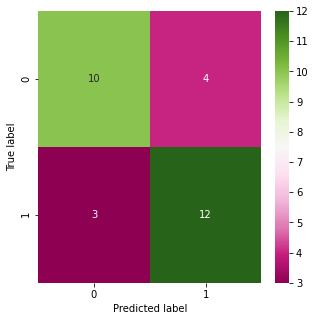

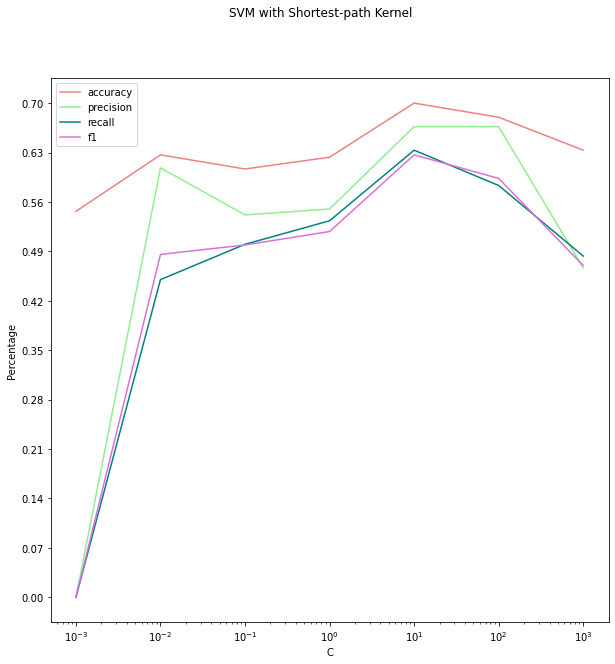

In [5]:
X, Y = extract_dataset("PPI")
X = shortest_path_kernel(X)
find_right_svm(X, Y, plot_title='SVM with Shortest-path Kernel')

<a id="1.1.1"/></a>
### 1.1.1 Plot decision boundary

Text(0.5, 0.98, 'SVM decision boundary')

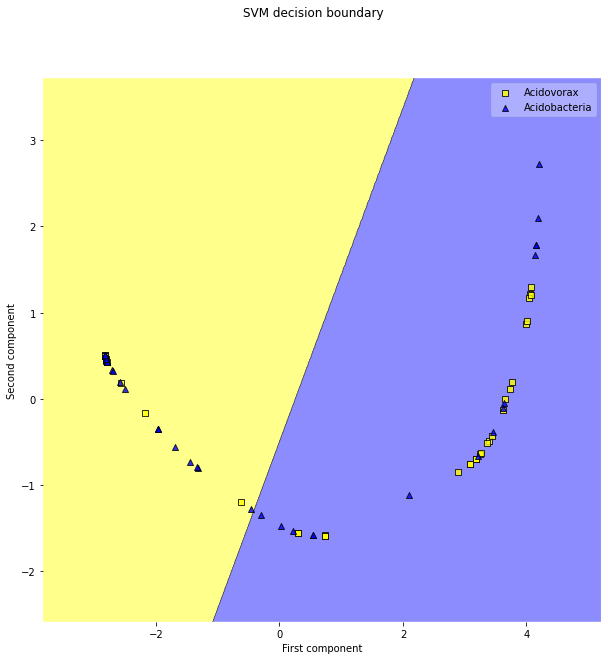

In [6]:
# Loading dataset
X, y = extract_dataset("PPI")
# executing matrix of similarity
X = shortest_path_kernel(X)
# apply PCA
X = PCA(n_components=2).fit_transform(X)
# Training a classifier
svm = SVC(kernel='linear', C=10)
svm.fit(X, y)
# create plot
f, ax = plt.subplots(1, 1, figsize = (10, 10))
# Plotting decision regions
plot_decision_regions(X, y, clf=svm, legend=2, ax=ax, colors='yellow,blue')
# change name axes
ax.set_ylabel("Second component")
ax.set_xlabel("First component")
# change names in legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Acidovorax', 'Acidobacteria'], 
           framealpha=0.3, scatterpoints=1)
# insert title
f.suptitle('SVM decision boundary')

<a id="1.2"/></a>
## 1.2 With Manifold

In [10]:
# FUNCTIONS TO TUNING SVM AND PLOT RESULTS

# determine various metric with different hyperparameters to find the best configuration for the classifier
def find_right_svm_manifold(X, Y, emphasy = 1, plot_title="SVM", kernel="linear"):
    # vector to plot
    v_precision=[]; v_recall=[]; v_f1=[]; v_accuracy=[]
    # C is a hypermeter in SVM to control error
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    # parameter to determine the number of neighbors for the manifold
    N_neighbors_manifold = [2, 4, 8, 16, 32, 64]
    # parameter to determine the number of components that manifold must hold
    N_components_manifold = [2, 4, 8, 16, 32, 64]
    for n_neig in N_neighbors_manifold:
        # vector to plot for neighbors
        tmp_N_v_precision=[]; tmp_N_v_recall=[]; tmp_N_v_f1=[]; tmp_N_v_accuracy=[]
        for n_com in N_components_manifold:
            # vector to plot for components
            tmp_C_v_precision=[]; tmp_C_v_recall=[]; tmp_C_v_f1=[]; tmp_C_v_accuracy=[]
            # create manifold and transform data
            X_tr = Isomap(n_components=n_com, n_neighbors=n_neig).fit_transform(X)
            # split train set in train and validation
            x_train, x_test, y_train, y_test = train_test_split(X_tr, Y, test_size=0.33, random_state=42)
            for c in C:
                # create instance of classificator
                svm_tmp = SVC(kernel=kernel, C=c)
                # make a custom scorer for a measure (more enphasy about precision)
                ftwo_scorer = make_scorer(fbeta_score, beta=emphasy)
                ftwo_precision = make_scorer(precision_score, zero_division = 0)
                # various measures for each distance that they are inserted inside a list for hyperparam C
                tmp_C_v_accuracy.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1).mean())
                tmp_C_v_precision.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_precision, n_jobs=-1).mean())
                tmp_C_v_recall.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='recall', n_jobs=-1).mean())
                tmp_C_v_f1.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_scorer, n_jobs=-1).mean())
            # insert inside the external list that I need to plot in a right way for hyperparam n_components
            tmp_N_v_precision.append(tmp_C_v_precision)
            tmp_N_v_recall.append(tmp_C_v_recall)
            tmp_N_v_f1.append(tmp_C_v_f1)
            tmp_N_v_accuracy.append(tmp_C_v_accuracy)
        # insert inside the external list that I need to plot in a right way for hyperparam n_neighborns
        v_precision.append(tmp_N_v_precision)
        v_recall.append(tmp_N_v_recall)
        v_f1.append(tmp_N_v_f1)
        v_accuracy.append(tmp_N_v_accuracy)
    best_result_svm_manifold(C,  N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1, X, Y, kernel)
    plot_report_svm_manifold(C, v_accuracy, v_precision, v_recall, v_f1, plot_title, N_neighbors_manifold, N_components_manifold)
    
    
# plot the results    
def plot_report_svm_manifold(C, v_a, v_p, v_r, v_f1, plot_title, N_neighbors_manifold, N_components_manifold):
    # make subplot figure NB: parameter constrained_layout maintains the distance among subplots
    fig, axs = plt.subplots(int((len(N_components_manifold)/3)*len(N_neighbors_manifold)), 3, figsize=(100,90), constrained_layout = True)  
    # need to give the right axes to each plot
    row_axes, col_axes = 0, 0
    # title of main graphic
    fig.suptitle(plot_title, fontsize = 60)
    for i in range(0, len(v_a)):
        # each of them contains a list where each list is a plot
        tmp_v_a = v_a[i]
        tmp_v_p = v_p[i]
        tmp_v_r = v_r[i]
        tmp_v_f1 = v_f1[i]
        for n in range(0, len(tmp_v_a)): #first row
            axs[row_axes, col_axes].plot(C, tmp_v_a[n], label="accuracy", color="gray")
            axs[row_axes, col_axes].plot(C, tmp_v_p[n], label="precision", color="lightgreen")
            axs[row_axes, col_axes].plot(C, tmp_v_r[n], label="recall", color="teal")
            axs[row_axes, col_axes].plot(C, tmp_v_f1[n], label="f1", color="orchid")
            axs[row_axes, col_axes].set_ylabel("Percentage", fontsize = 50)
            axs[row_axes, col_axes].set_xlabel("C", fontsize = 50)
            # set xticks and fontsize of them
            axs[row_axes, col_axes].set_xticks(C)
            # use logaritmic scale
            axs[row_axes, col_axes].set_xscale('log')
            # min of all measures
            compute_min = min(min(tmp_v_a[n]), min(tmp_v_p[n]), min(tmp_v_r[n]), min(tmp_v_f1[n]))
            # max of all measures
            compute_max = max(max(tmp_v_a[n]), max(tmp_v_p[n]), max(tmp_v_r[n]), max(tmp_v_f1[n]))
            # margin of increment that I want for this graphic
            margin_of_increment = (compute_max - compute_min)/10
            # set margins
            # determine the yticks in axes y
            y_ticks = np.arange(compute_min, compute_max+margin_of_increment, margin_of_increment)
            # all y_ticks must have 3 digit after comma
            y_ticks = [round(y_t, 3) for y_t in y_ticks]
            # set y ticks
            axs[row_axes, col_axes].set_yticks(y_ticks)
            # increase the dimension of ticks and labels
            axs[row_axes, col_axes].tick_params('both', length=20, width=2, which='major', labelsize=40)
            # set title for subplot
            axs[row_axes, col_axes].set_title(f"Number of neighbors: {2**(i+1)} | Number of components: {2**(n+1)}", fontsize = 40)
            axs[row_axes, col_axes].legend(fontsize = 40)
            # change the row for the plot or change col
            if col_axes == 2:
                col_axes = 0
                row_axes += 1
            else:
                col_axes += 1
        
# find the best hyperparameters
def best_result_svm_manifold(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1, X, Y, kernel):
    # find best hyperparameters to find the highest score
    max_tupla = estimate_best_manifold(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1)
    # create manifold and transform data
    X_tr = Isomap(n_components=max_tupla[2], n_neighbors=max_tupla[3]).fit_transform(X)
    # split train set in train and validation
    x_train, x_test, y_train, y_test = train_test_split(X_tr, Y, test_size=0.33, random_state=42)
    # create the figure
    f, ax = plt.subplots(1, 1, figsize = (5, 5))
    # create instance of classifier
    svm = SVC(C=max_tupla[1], kernel=kernel)
    # train instance
    svm.fit(x_train, y_train)
    # predict the y_hat
    y_hat = svm.predict(x_test)
    # plot confusion matrix
    sn.heatmap(confusion_matrix(y_test, y_hat), annot=True, ax=ax, fmt="d", cmap="PiYG") 
    # define labels name for confusion matrix
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    # print the best hyperparameters
    print("The best hyperparameters are: C ={:.2f}".format(max_tupla[1]), f"\nN_components: {max_tupla[2]}\nN_neighbors: {max_tupla[3]}")
    # print result during validation time
    print_mean_std_of_cross_validation(max_tupla[1], x_train, y_train, kernel)
    # print various metrics in test time
    print("---METRICS AT THE TEST TIME---")
    print("Accuracy: ", accuracy_score(y_hat, y_test))
    print("Precision: ", recall_score(y_hat, y_test, zero_division = 0))
    print("Recall: ", precision_score(y_hat, y_test, zero_division = 0))
    print("F1_score: ", f1_score(y_hat, y_test))

    
# find the best hyperparameters to increase the score
def estimate_best_manifold(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1):
    # holds the best performance with the hyperparameters to find it
    list_of_best = []
    for neigh, (neigh_l_a, neigh_l_f) in enumerate(zip(v_accuracy, v_f1)):
        for comp, (comp_l_a, comp_l_f) in enumerate(zip(neigh_l_a, neigh_l_f)):
            # compute the mean to find the best hyperparameter C for a specific n_components and n_neighborns
            tmp_sum = [(x + y)/2 for x, y in zip(comp_l_a, comp_l_f)]
            # tupla with              (best value, hyperparameter C, hyperparameter n_components, hyperparameter n_neighborn)
            list_of_best.append((np.max(tmp_sum), C[np.argmax(tmp_sum)], N_components_manifold[comp], N_neighbors_manifold[neigh]))
    # find the best tupla
    return max(list_of_best, key= lambda item: item[0])


The best hyperparameters are: C =100.00 
N_components: 8
N_neighbors: 32
---METRICS AT THE VALIDATION TIME---
Metric         Mean       Std
---------  --------  --------
Accuracy   0.753333  0.208273
Precision  0.716667  0.32532
Recall     0.633333  0.339935
F-score    0.656667  0.322852
---METRICS AT THE TEST TIME---
Accuracy:  0.7931034482758621
Precision:  0.7857142857142857
Recall:  0.7857142857142857
F1_score:  0.7857142857142857


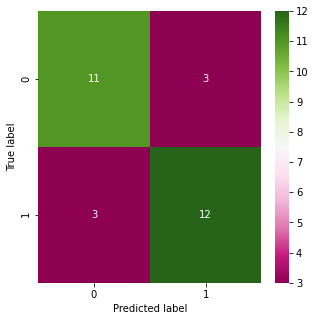

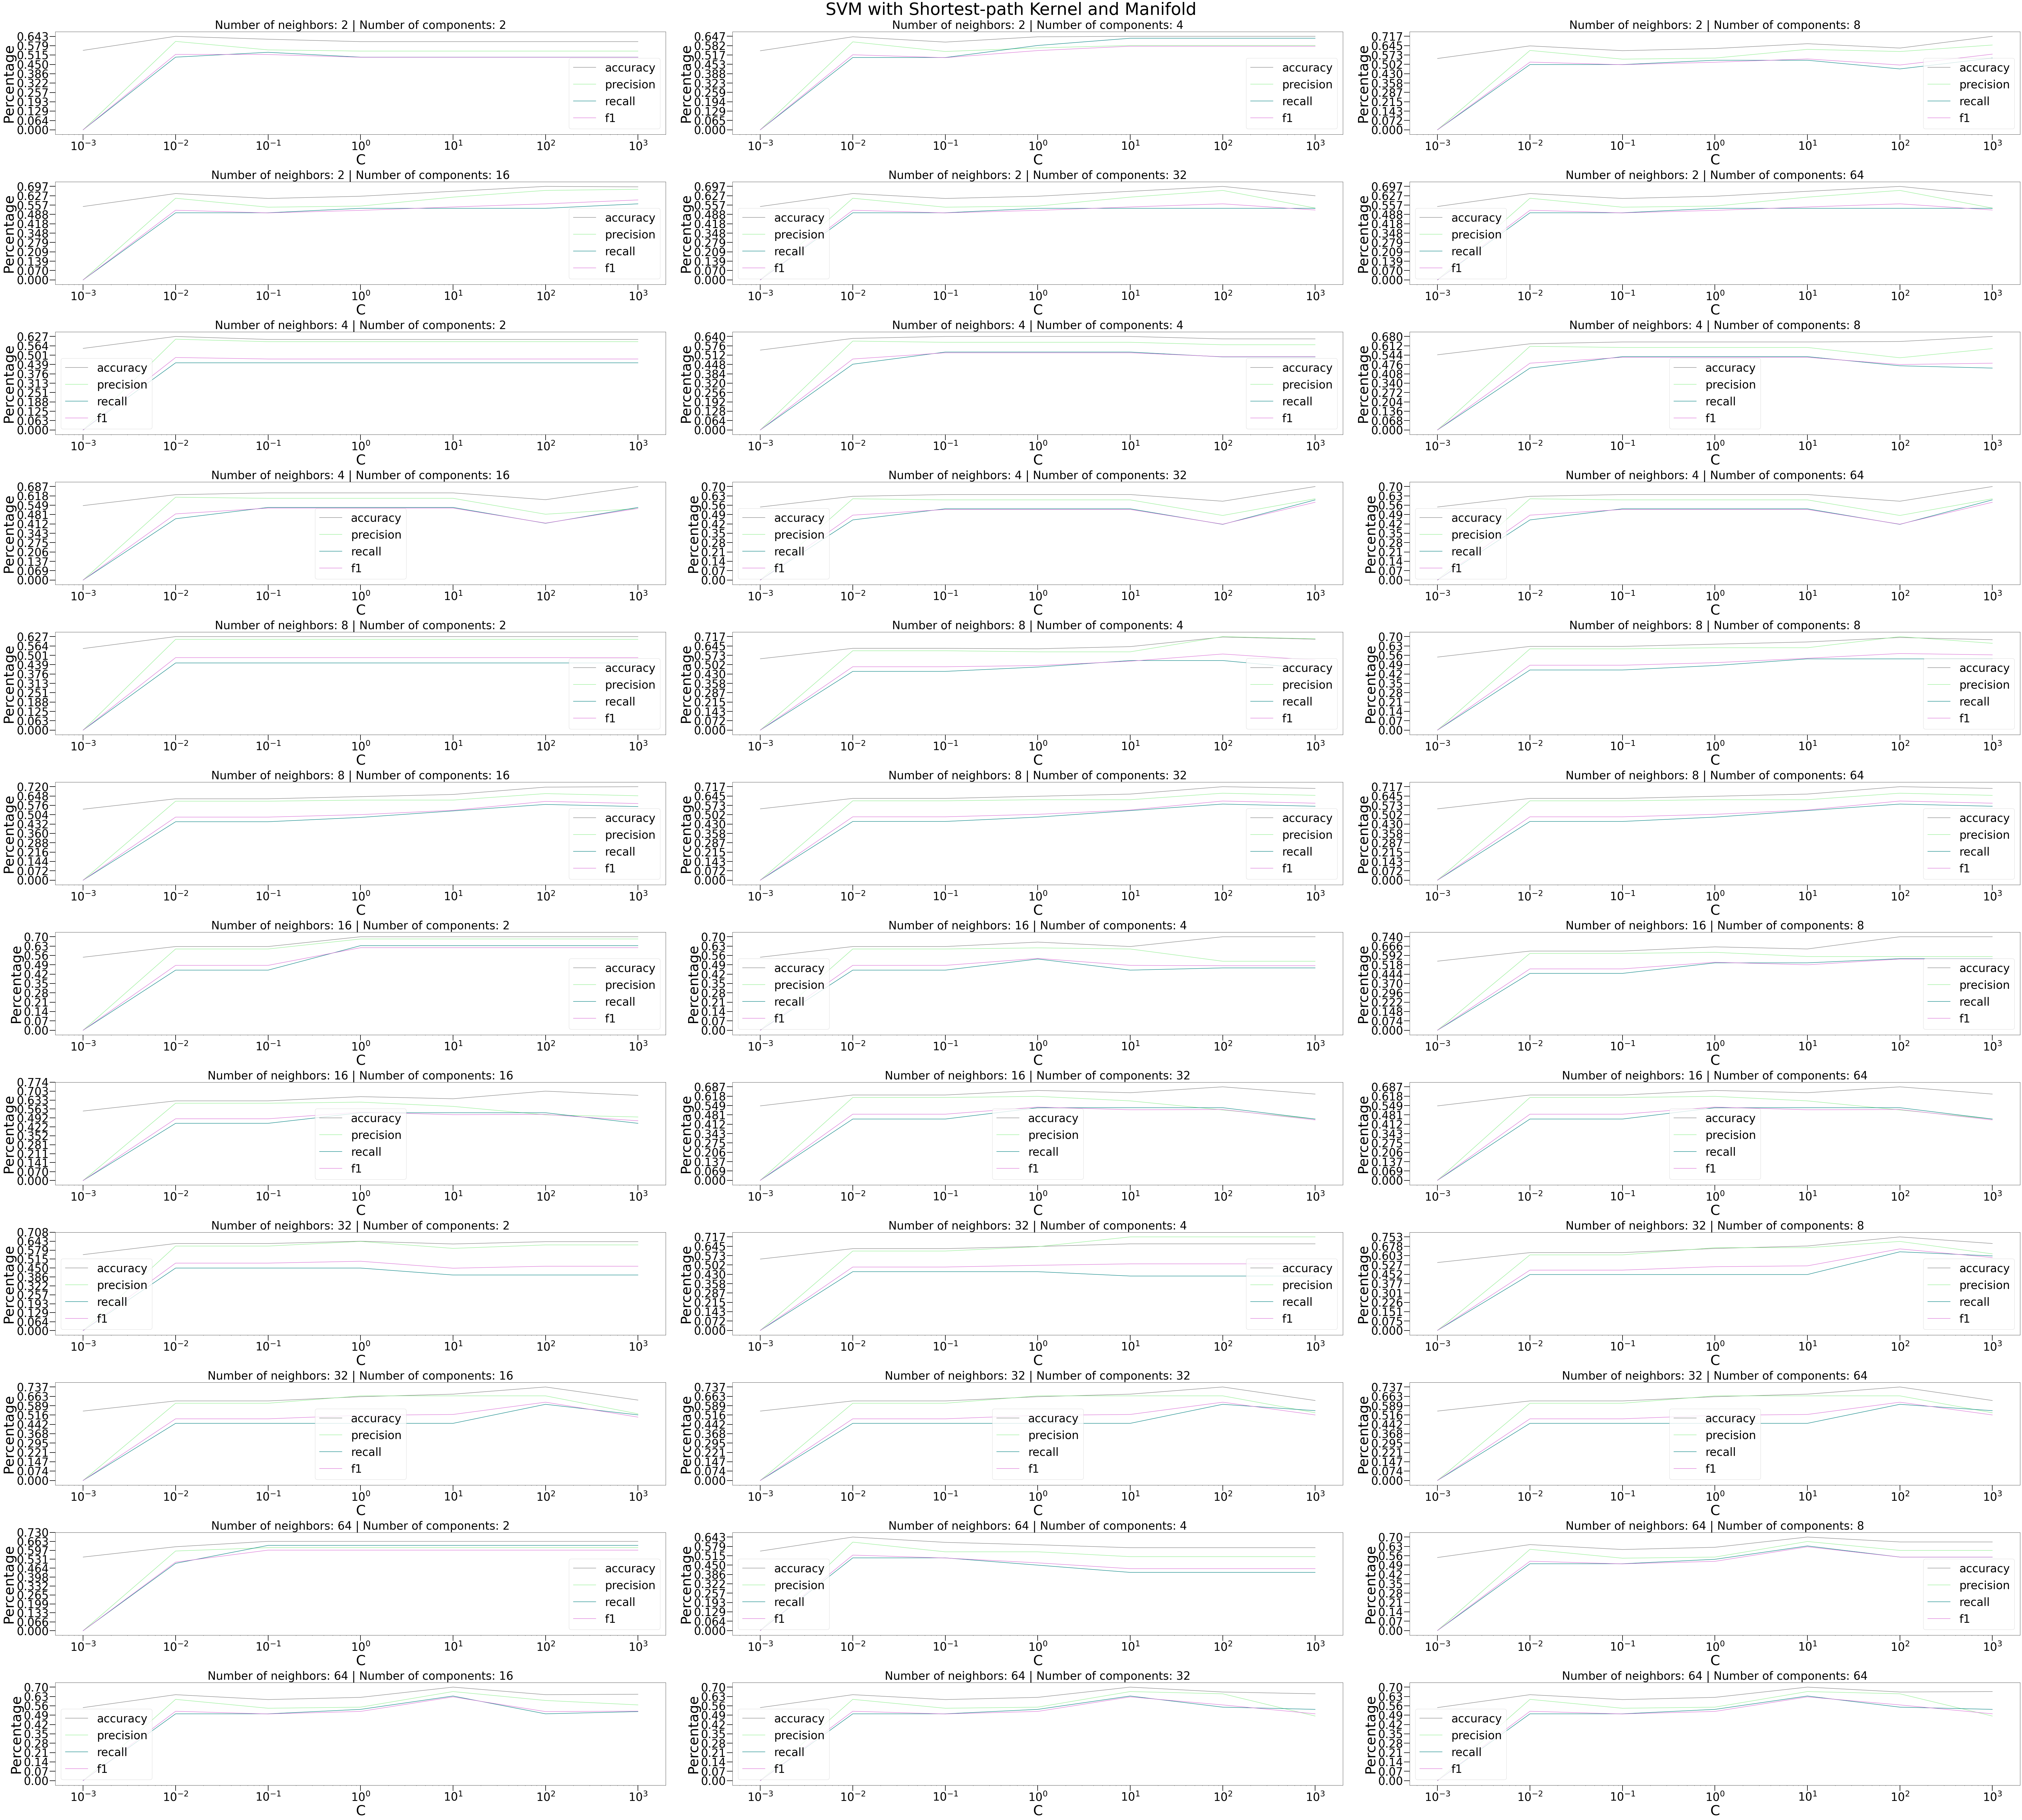

In [11]:
X, Y = extract_dataset("PPI")
# compute the similarity matrix
X = shortest_path_kernel(X)
# find the best
find_right_svm_manifold(X, Y, plot_title='SVM with Shortest-path Kernel and Manifold')

<a id="1.2.1"/></a>
### 1.2.1 Plot decision boundary

Text(0.5, 0.98, 'SVM decision boundary with Manifold')

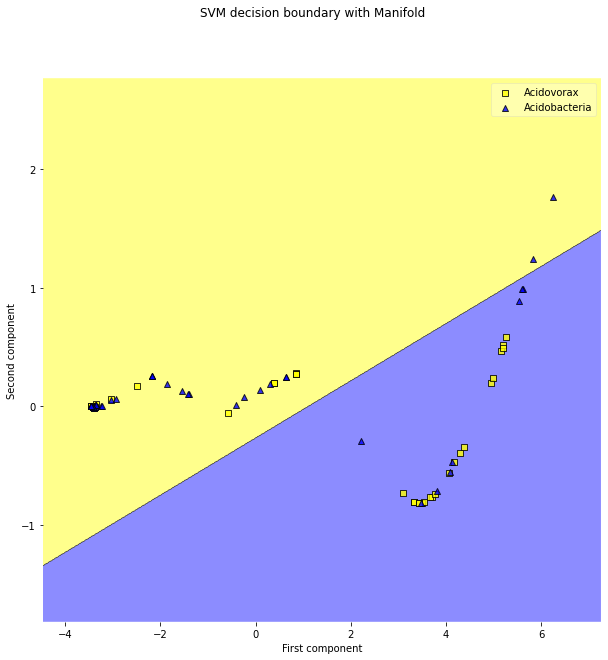

In [9]:
# Loading dataset
X, y = extract_dataset("PPI")
# executing matrix of similarity
X = shortest_path_kernel(X)
# apply Manifold
X = Isomap(n_components=8, n_neighbors=32).fit_transform(X)
# Training a classifier
svm = SVC(kernel='linear', C=100)
svm.fit(X, y)
# create plot
f, ax = plt.subplots(1, 1, figsize = (10, 10))
# Plotting decision regions
# it indicates in that point the other (those not displayed) coordinates must be held fixed
value = 0
# it indicates how many these coordinates can move
width = 1
plot_decision_regions(X, y, clf=svm, legend=2, ax=ax, colors='yellow,blue', 
                        filler_feature_values={i:value for i in range(2, 8)},
                        filler_feature_ranges={i:width for i in range(2, 8)})
# change name axes
ax.set_ylabel("Second component")
ax.set_xlabel("First component")
# change names in legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Acidovorax', 'Acidobacteria'], 
           framealpha=0.3, scatterpoints=1)
# insert title
f.suptitle('SVM decision boundary with Manifold')

<a id="1.2.2"/></a>
### 1.2.2 Plot for Report

In [12]:
# create the plot for report
def plotting_for_report(X, Y, emphasy = 1, kernel="linear"):
    # vector to plot
    v_precision=[]; v_recall=[]; v_f1=[]; v_accuracy=[]
    # C is a hypermeter in SVM to control error
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    # parameter to determine the number of neighbors for the manifold
    N_neighbors_manifold = [2, 4, 8, 16, 32, 64]
    # parameter to determine the number of components that manifold must hold
    N_components_manifold = [2, 4, 8, 16, 32, 64]
    for n_neig in N_neighbors_manifold:
        # vector to plot for neighbors
        tmp_N_v_precision=[]; tmp_N_v_recall=[]; tmp_N_v_f1=[]; tmp_N_v_accuracy=[]
        for n_com in N_components_manifold:
            # vector to plot for components
            tmp_C_v_precision=[]; tmp_C_v_recall=[]; tmp_C_v_f1=[]; tmp_C_v_accuracy=[]
            # create manifold and transform data
            X_tr = Isomap(n_components=n_com, n_neighbors=n_neig).fit_transform(X)
            # split train set in train and validation
            x_train, x_test, y_train, y_test = train_test_split(X_tr, Y, test_size=0.33, random_state=42)
            for c in C:
                # create instance of classificator
                svm_tmp = SVC(kernel=kernel, C=c)
                # make a custom scorer for a measure (more enphasy about precision)
                ftwo_scorer = make_scorer(fbeta_score, beta=emphasy)
                ftwo_precision = make_scorer(precision_score, zero_division = 0)
                # various measures for each distance that they are inserted inside a list for hyperparam C
                tmp_C_v_accuracy.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1).mean())
                tmp_C_v_precision.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_precision, n_jobs=-1).mean())
                tmp_C_v_recall.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='recall', n_jobs=-1).mean())
                tmp_C_v_f1.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_scorer, n_jobs=-1).mean())
            # insert inside the external list that I need to plot in a right way for hyperparam n_components
            tmp_N_v_precision.append(tmp_C_v_precision)
            tmp_N_v_recall.append(tmp_C_v_recall)
            tmp_N_v_f1.append(tmp_C_v_f1)
            tmp_N_v_accuracy.append(tmp_C_v_accuracy)
        # insert inside the external list that I need to plot in a right way for hyperparam n_neighborns
        v_precision.append(tmp_N_v_precision)
        v_recall.append(tmp_N_v_recall)
        v_f1.append(tmp_N_v_f1)
        v_accuracy.append(tmp_N_v_accuracy)
    l_b = best_for_plot(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1)
    print_graph_for_report(l_b, N_neighbors_manifold, N_components_manifold)



# find the best hyperparameters for each neigh and comp
def best_for_plot(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1):
    # holds the best performance with the hyperparameters to find it
    list_of_best = []
    for neigh, (neigh_l_a, neigh_l_f) in enumerate(zip(v_accuracy, v_f1)):
        for comp, (comp_l_a, comp_l_f) in enumerate(zip(neigh_l_a, neigh_l_f)):
            # compute the mean to find the best hyperparameter C for a specific n_components and n_neighborns
            tmp_sum = [(x + y)/2 for x, y in zip(comp_l_a, comp_l_f)]
            # tupla with              (best value, hyperparameter C, hyperparameter n_components, hyperparameter n_neighborn)
            list_of_best.append((np.max(tmp_sum), C[np.argmax(tmp_sum)], N_components_manifold[comp], N_neighbors_manifold[neigh]))
    return list_of_best


# print graph for report
def print_graph_for_report(l_b, N_neighbors_manifold, N_components_manifold):
    # sort by components
    sort_by_comp = sorted(l_b, key=lambda item: item[2])
    # sort by neighborns
    sort_by_neig = sorted(l_b, key=lambda item: item[3])
    # lists for graphs
    l_print_comp, l_print_neig = [], []
    # CREATE LIST FOR PLOT FOR COMPONENTS
    # iterator for move the list of N_neighbors_manifold and N_components_manifold to find the list for plot
    it = 0
    # holds the max value
    maxi = 0
    for t_comp in sort_by_comp:
        if t_comp[2] != N_components_manifold[it]:
            # change component
            it+=1
            l_print_comp.append(maxi)
            # restart maxi
            maxi = 0
        if t_comp[0] > maxi:
            maxi = t_comp[0]
    l_print_comp.append(maxi)
    # CREATE LIST FOR PLOT FOR NEIGHBORNS
    # iterator for move the list of N_neighbors_manifold and N_components_manifold to find the list for plot
    it = 0
    # holds the max value
    maxi = 0
    # create list for plot for components
    for t_neig in sort_by_neig:
        if t_neig[3] != N_neighbors_manifold[it]:
            # change component
            it+=1
            l_print_neig.append(maxi)
            # restart maxi
            maxi = 0
        if t_neig[0] > maxi:
            maxi = t_neig[0]
    l_print_neig.append(maxi)
    # create graphs
    fig, axs = plt.subplots(1, 2, figsize=(20,10), constrained_layout = True)  
    for ax, plot in zip(axs, [(N_components_manifold,l_print_comp, "orchid", "n_components"), (N_neighbors_manifold,l_print_neig, "teal", "n_neighbors")]):
        ax.plot(plot[0], plot[1], color=plot[2], linewidth=5)
        ax.set_ylabel("mean between accuracy and f1-score", fontsize = 15)
        ax.set_xlabel(plot[3], fontsize = 15)
        ax.set_xscale('log', base=2)
        ax.set_yticks(plot[1])
        ax.tick_params('both', length=20, width=2, which='major', labelsize=10)
        
    
    
    

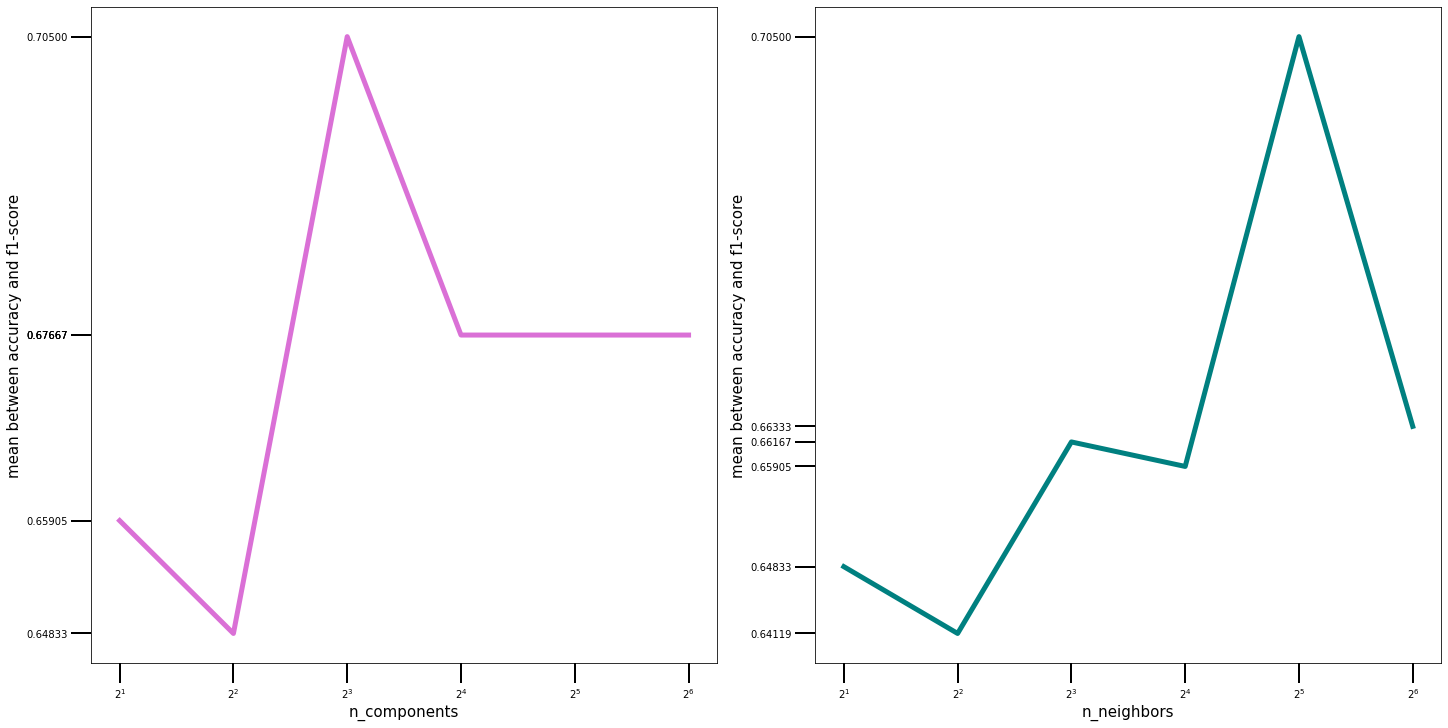

In [13]:
X, Y = extract_dataset("PPI")
# compute the similarity matrix
X = shortest_path_kernel(X)
plotting_for_report(X, Y)

<a id="2"/></a>
# 2 SHOCK Dataset

In [16]:
# determine various metric with different hyperparameters to find the best configuration for the classifier
def find_right_svm_multi(X, Y, emphasy = 1, plot_title="SVM", kernel="linear"):
    # split train set in train and validation
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    # vector to plot
    v_precision, v_recall, v_f1, v_accuracy = [], [], [], []
    # C is a hypermeter in SVM to control error
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    # decision function for multiclass problem
    M = ['ovr', 'ovo']
    for multi_method in M:
        tmp_precision, tmp_recall, tmp_f1, tmp_accuracy = [], [], [], []
        for c in C:
            # create instance of classificator
            svm_tmp = SVC(C=c, decision_function_shape=multi_method, kernel=kernel)
            # make a custom scorer for a measure (more enphasy about precision)
            ftwo_scorer = make_scorer(fbeta_score, beta=emphasy, average='macro')
            ftwo_precision = make_scorer(precision_score, zero_division = 0, average='macro')
            ftwo_recall = make_scorer(recall_score, zero_division = 0, average='macro')
            # various measures for each distance
            tmp_accuracy.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean())
            tmp_precision.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_precision, n_jobs=-1).mean())
            tmp_recall.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_recall, n_jobs=-1).mean())
            tmp_f1.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_scorer, n_jobs=-1).mean())
        # add measures to plot vectors
        v_precision.append(tmp_precision)
        v_recall.append(tmp_recall)
        v_f1.append(tmp_f1)
        v_accuracy.append(tmp_accuracy)
    best_result_svm_multi(C, v_accuracy, v_precision, v_recall, v_f1, x_train, x_test, y_train, y_test, kernel)
    plot_report_svm_multi(C, M, v_accuracy, v_precision, v_recall, v_f1, plot_title)
    
    
# plot the results    
def plot_report_svm_multi(C, M, v_a, v_p, v_r, v_f1, plot_title):
    # make figure
    fig = plt.figure(constrained_layout=False, figsize=(15, 7*len(M)))
    # make grid of plots
    gs = fig.add_gridspec(nrows=5+(len(M)*6), ncols=3)  
    # holds all axes
    axs= []
    # determine number of subplot
    for i in range(len(M)):
        axs.append(fig.add_subplot(gs[0+6*i:5+6*i, 0:3]))
    # title of main graphic
    fig.suptitle(plot_title)
    for i, ax in enumerate(axs): #first row
        ax.plot(C, v_a[i], label="accuracy", color="gray")
        ax.plot(C, v_p[i], label="precision", color="lightgreen")
        ax.plot(C, v_r[i], label="recall", color="teal")
        ax.plot(C, v_f1[i], label="f1", color="orchid")
        ax.set_ylabel("Percentage")
        ax.set_xlabel("C")
        ax.set_xticks(C)
        # use logaritmic scale
        ax.set_xscale('log')
        # min of all measures
        compute_min = min(min(v_a[i]), min(v_p[i]), min(v_r[i]), min(v_f1[i]))
        # max of all measures
        compute_max = max(max(v_a[i]), max(v_p[i]), max(v_r[i]), max(v_f1[i]))
        # margin of increment that I want for these graphics
        margin_of_increment = (compute_max - compute_min)/10
        # set margins
        ax.set_yticks(np.arange(compute_min, compute_max+margin_of_increment, margin_of_increment))
        ax.title.set_text(f"Decision function {M[i]}")
        ax.legend()
        
# find the best hyperparameters
def best_result_svm_multi(C, v_a, v_p, v_r, v_f1, x_train, x_test, y_train, y_test, kernel):
    # list that contain a pair(C, max_value)
    tmp_max=[]
    for a, f1 in zip(v_a, v_f1):
        # list that hold the sum of all metrics
        tmp_sum = [(x + y)/2 for x, y in zip(a, f1)]
        tmp_max.append((C[tmp_sum.index(max(tmp_sum))], max(tmp_sum)))
    # hold the tupla with the best hyperparameters (metric, C)
    best = (0, 0)
    # hold the best value of tmp_max
    val = 0
    # find the max value and save the right poly degree
    for i, t in enumerate(tmp_max):
        if val < t[1]:
            val = t[1]
            #      decision func| pos for vector C
            best = (i, t[0])
    # create figure
    f, ax = plt.subplots(1, 1, figsize = (5, 5))
    # create instance of classifier
    svm = SVC(C=best[1], decision_function_shape="ovr" if best[0] == 0 else "ovo", kernel=kernel)
    # train instance
    svm.fit(x_train, y_train)
    # predict the y_hat
    y_hat = svm.predict(x_test)
    # plot confusion matrix
    sn.heatmap(confusion_matrix(y_test, y_hat), annot=True, ax=ax, fmt="d", cmap="PiYG") 
    # define labels name
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    # print various metrics
    print("The best hyperparameters are: C ={:.2f}".format(best[1]), "| Decision function =",
          "One vs Rest" if best[0] == 0 else "One vs One")
    # print metrics in validation time
    print_mean_std_of_cross_validation_multi(best[1], "ovr" if best[0] == 0 else "ovo", x_train, y_train, kernel)
    print("---METRICS AT THE TEST TIME---")
    print("Accuracy: ", accuracy_score(y_hat, y_test))
    print("Precision: ", recall_score(y_hat, y_test, average='macro', zero_division = 0))
    print("Recall: ", precision_score(y_hat, y_test, average='macro', zero_division = 0))
    print("F1_score: ", f1_score(y_hat, y_test, average='macro'))
    
    
# print the metric in cross val with std deviation using the best model
def print_mean_std_of_cross_validation_multi(c, d, x_train, y_train, kernel):
    svm_tmp = SVC(C=c, kernel=kernel, decision_function_shape=d)
    # make a custom scorer for a measure (more enphasy about precision)
    ftwo_scorer = make_scorer(fbeta_score, beta=1, average='macro')
    ftwo_precision = make_scorer(precision_score, zero_division = 0, average='macro')
    ftwo_recall = make_scorer(recall_score, zero_division = 0, average='macro')
    
    # execution of cross validation
    acc = cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    prec = cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_precision, n_jobs=-1)
    rec = cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_recall, n_jobs=-1)
    f1 = cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_scorer, n_jobs=-1)
    list_tmp=[]
    # create the list for print table
    for metric, name in zip([acc, prec, rec, f1], ["Accuracy" ,"Precision", "Recall", "F-score"]):
        list_tmp.append([name, metric.mean(), metric.std()])
    # print table
    print("---METRICS AT THE VALIDATION TIME---")
    print(tabulate(list_tmp, headers=["Metric", "Mean", "Std"]))    


<a id="2.1"/></a>
## 2.1 Without Manifold

The best hyperparameters are: C =1000.00 | Decision function = One vs Rest
---METRICS AT THE VALIDATION TIME---
Metric         Mean        Std
---------  --------  ---------
Accuracy   0.34      0.02
Precision  0.267333  0.0551422
Recall     0.33      0.0286744
F-score    0.271143  0.0339061
---METRICS AT THE TEST TIME---
Accuracy:  0.3
Precision:  0.21753968253968253
Recall:  0.395
F1_score:  0.25982517482517486


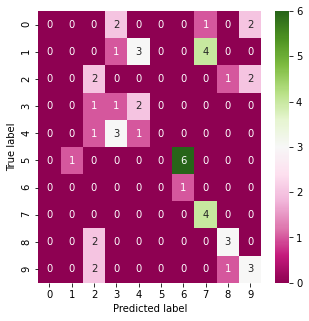

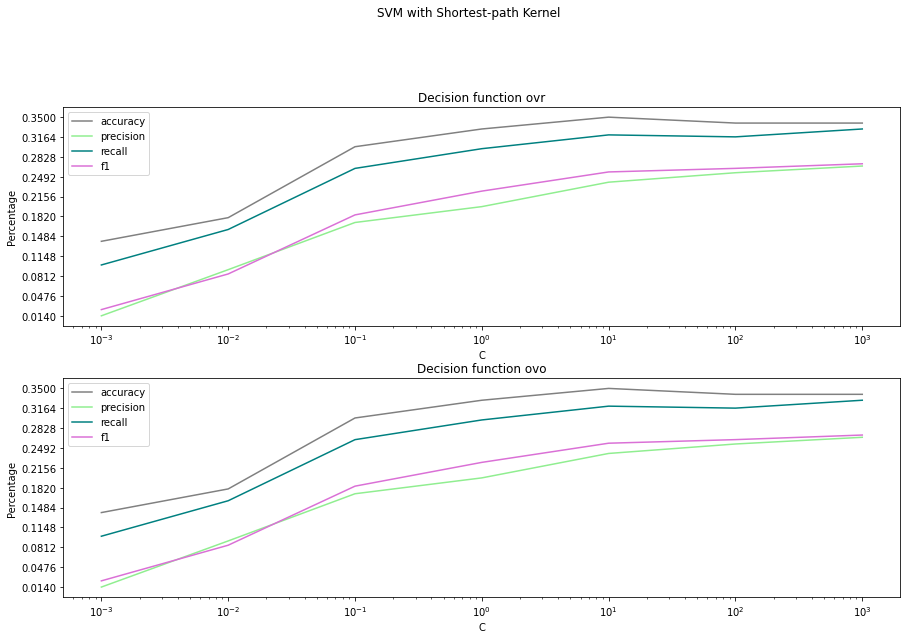

In [11]:
X, Y = extract_dataset("SHOCK")
X = shortest_path_kernel(X)
find_right_svm_multi(X, Y, plot_title='SVM with Shortest-path Kernel')

<a id="2.1.1"/></a>
### 2.1.1 Plot decision boundary

Text(0.5, 0.98, 'SVM decision boundary')

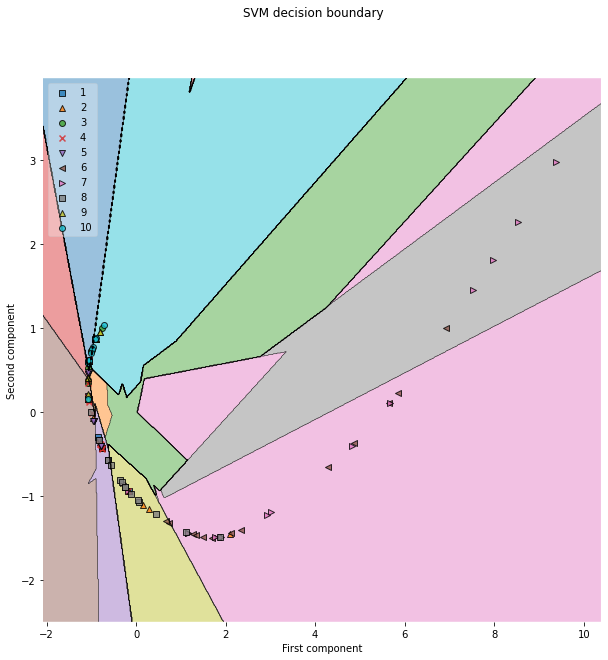

In [12]:
# Loading dataset
X, y = extract_dataset("SHOCK")
# executing matrix of similarity
X = shortest_path_kernel(X)
# apply PCA
X = PCA(n_components=2).fit_transform(X)
# Training a classifier
svm = SVC(kernel='linear', C=1000, decision_function_shape='ovr')
svm.fit(X, y)
# create plot
f, ax = plt.subplots(1, 1, figsize = (10, 10))
# Plotting decision regions
plot_decision_regions(X, y, clf=svm, legend=2, ax=ax)
# change name axes
ax.set_ylabel("Second component")
ax.set_xlabel("First component")
# insert title
f.suptitle('SVM decision boundary')

<a id="2.2"/></a>
## 2.2 With Manifold

In [14]:
# FUNCTIONS TO TUNING SVM AND PLOT RESULTS

# determine various metric with different hyperparameters to find the best configuration for the classifier
def find_right_svm_manifold_multi(X, Y, emphasy = 1, plot_title="SVM", kernel="linear"):
    # vector to plot
    v_precision=[]; v_recall=[]; v_f1=[]; v_accuracy=[]
    # C is a hypermeter in SVM to control error
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    # parameter to determine the number of neighbors for the manifold
    N_neighbors_manifold = [2, 4, 8, 16, 32, 64]
    # parameter to determine the number of components that manifold must hold
    N_components_manifold = [2, 4, 8, 16, 32, 64]
    for n_neig in N_neighbors_manifold:
        # vector to plot for neighbors
        tmp_N_v_precision=[]; tmp_N_v_recall=[]; tmp_N_v_f1=[]; tmp_N_v_accuracy=[]
        for n_com in N_components_manifold:
            # vector to plot for components
            tmp_C_v_precision=[]; tmp_C_v_recall=[]; tmp_C_v_f1=[]; tmp_C_v_accuracy=[]
            # create manifold and transform data
            X_tr = Isomap(n_components=n_com, n_neighbors=n_neig).fit_transform(X)
            # split train set in train and validation
            x_train, x_test, y_train, y_test = train_test_split(X_tr, Y, test_size=0.33, random_state=42)
            for c in C:
                # create instance of classificator
                svm_tmp = SVC(kernel=kernel, C=c, decision_function_shape='ovo')
                # make a custom scorer for a measure (more enphasy about precision)
                ftwo_scorer = make_scorer(fbeta_score, beta=emphasy, average='macro')
                ftwo_precision = make_scorer(precision_score, zero_division = 0, average='macro')
                ftwo_recall = make_scorer(recall_score, zero_division = 0, average='macro')
                # various measures for each distance that they are inserted inside a list for hyperparam C
                tmp_C_v_accuracy.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean())
                tmp_C_v_precision.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_precision, n_jobs=-1).mean())
                tmp_C_v_recall.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_recall, n_jobs=-1).mean())
                tmp_C_v_f1.append(cross_val_score(svm_tmp, x_train, y_train, cv=5, scoring=ftwo_scorer, n_jobs=-1).mean())
            # insert inside the external list that I need to plot in a right way for hyperparam n_components
            tmp_N_v_precision.append(tmp_C_v_precision)
            tmp_N_v_recall.append(tmp_C_v_recall)
            tmp_N_v_f1.append(tmp_C_v_f1)
            tmp_N_v_accuracy.append(tmp_C_v_accuracy)
        # insert inside the external list that I need to plot in a right way for hyperparam n_neighborns
        v_precision.append(tmp_N_v_precision)
        v_recall.append(tmp_N_v_recall)
        v_f1.append(tmp_N_v_f1)
        v_accuracy.append(tmp_N_v_accuracy)
    best_result_svm_manifold_multi(C,  N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1, X, Y, kernel)
    plot_report_svm_manifold_multi(C, v_accuracy, v_precision, v_recall, v_f1, plot_title, N_neighbors_manifold, N_components_manifold)
    
    
# plot the results    
def plot_report_svm_manifold_multi(C, v_a, v_p, v_r, v_f1, plot_title, N_neighbors_manifold, N_components_manifold):
    # make subplot figure NB: parameter constrained_layout maintains the distance among subplots
    fig, axs = plt.subplots(int((len(N_components_manifold)/3)*len(N_neighbors_manifold)), 3, figsize=(100,90), constrained_layout = True)  
    # need to give the right axes to each plot
    row_axes, col_axes = 0, 0
    # title of main graphic
    fig.suptitle(plot_title, fontsize = 60)
    for i in range(0, len(v_a)):
        # each of them contains a list where each list is a plot
        tmp_v_a = v_a[i]
        tmp_v_p = v_p[i]
        tmp_v_r = v_r[i]
        tmp_v_f1 = v_f1[i]
        for n in range(0, len(tmp_v_a)): #first row
            axs[row_axes, col_axes].plot(C, tmp_v_a[n], label="accuracy", color="gray")
            axs[row_axes, col_axes].plot(C, tmp_v_p[n], label="precision", color="lightgreen")
            axs[row_axes, col_axes].plot(C, tmp_v_r[n], label="recall", color="teal")
            axs[row_axes, col_axes].plot(C, tmp_v_f1[n], label="f1", color="orchid")
            axs[row_axes, col_axes].set_ylabel("Percentage", fontsize = 50)
            axs[row_axes, col_axes].set_xlabel("C", fontsize = 50)
            # set xticks and fontsize of them
            axs[row_axes, col_axes].set_xticks(C)
            # use logaritmic scale
            axs[row_axes, col_axes].set_xscale('log')
            # min of all measures
            compute_min = min(min(tmp_v_a[n]), min(tmp_v_p[n]), min(tmp_v_r[n]), min(tmp_v_f1[n]))
            # max of all measures
            compute_max = max(max(tmp_v_a[n]), max(tmp_v_p[n]), max(tmp_v_r[n]), max(tmp_v_f1[n]))
            # margin of increment that I want for this graphic
            margin_of_increment = (compute_max - compute_min)/10
            # set margins
            # determine the yticks in axes y
            y_ticks = np.arange(compute_min, compute_max+margin_of_increment, margin_of_increment)
            # all y_ticks must have 3 digit after comma
            y_ticks = [round(y_t, 3) for y_t in y_ticks]
            # set y ticks
            axs[row_axes, col_axes].set_yticks(y_ticks)
            # increase the dimension of ticks and labels
            axs[row_axes, col_axes].tick_params('both', length=20, width=2, which='major', labelsize=40)
            # set title for subplot
            axs[row_axes, col_axes].set_title(f"Number of neighbors: {2**(i+1)} | Number of components: {2**(n+1)}", fontsize = 40)
            axs[row_axes, col_axes].legend(fontsize = 40)
            # change the row for the plot or change col
            if col_axes == 2:
                col_axes = 0
                row_axes += 1
            else:
                col_axes += 1
        
# find the best hyperparameters
def best_result_svm_manifold_multi(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1, X, Y, kernel):
    # find best hyperparameters to find the highest score
    max_tupla = estimate_best_manifold(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1)
    # create manifold and transform data
    X_tr = Isomap(n_components=max_tupla[2], n_neighbors=max_tupla[3]).fit_transform(X)
    # split train set in train and validation
    x_train, x_test, y_train, y_test = train_test_split(X_tr, Y, test_size=0.33, random_state=42)
    # create the figure
    f, ax = plt.subplots(1, 1, figsize = (5, 5))
    # create instance of classifier
    svm = SVC(C=max_tupla[1], kernel=kernel, decision_function_shape='ovo')
    # train instance
    svm.fit(x_train, y_train)
    # predict the y_hat
    y_hat = svm.predict(x_test)
    # plot confusion matrix
    sn.heatmap(confusion_matrix(y_test, y_hat), annot=True, ax=ax, fmt="d", cmap="PiYG") 
    # define labels name for confusion matrix
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    # print the best hyperparameters
    print("The best hyperparameters are: C ={:.2f}".format(max_tupla[1]), f"\nN_components: {max_tupla[2]}\nN_neighbors: {max_tupla[3]}")
    # print result during validation time
    print_mean_std_of_cross_validation_multi(max_tupla[1], 'ovo', x_train, y_train, kernel)
    # print various metrics in test time
    print("---METRICS AT THE TEST TIME---")
    print("Accuracy: ", accuracy_score(y_hat, y_test))
    print("Precision: ", recall_score(y_hat, y_test, zero_division = 0, average='macro'))
    print("Recall: ", precision_score(y_hat, y_test, zero_division = 0, average='macro'))
    print("F1_score: ", f1_score(y_hat, y_test, average='macro'))
    

    
# find the best hyperparameters to increase the score
def estimate_best_manifold(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1):
    # holds the best performance with the hyperparameters to find it
    list_of_best = []
    for neigh, (neigh_l_a, neigh_l_f) in enumerate(zip(v_accuracy, v_f1)):
        for comp, (comp_l_a, comp_l_f) in enumerate(zip(neigh_l_a, neigh_l_f)):
            # compute the mean to find the best hyperparameter C for a specific n_components and n_neighborns
            tmp_sum = [(x + y)/2 for x, y in zip(comp_l_a, comp_l_f)]
            # tupla with              (best value, hyperparameter C, hyperparameter n_components, hyperparameter n_neighborn)
            list_of_best.append((np.max(tmp_sum), C[np.argmax(tmp_sum)], N_components_manifold[comp], N_neighbors_manifold[neigh]))
    # find the best tupla
    return max(list_of_best, key= lambda item: item[0])
    

The best hyperparameters are: C =1000.00 
N_components: 32
N_neighbors: 2
---METRICS AT THE VALIDATION TIME---
Metric         Mean        Std
---------  --------  ---------
Accuracy   0.46      0.0734847
Precision  0.427     0.103931
Recall     0.446667  0.0541603
F-score    0.399619  0.0777655
---METRICS AT THE TEST TIME---
Accuracy:  0.38
Precision:  0.39527777777777773
Recall:  0.4692857142857142
F1_score:  0.35484959484959483


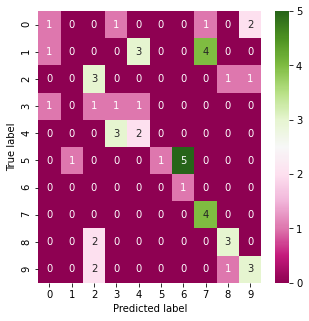

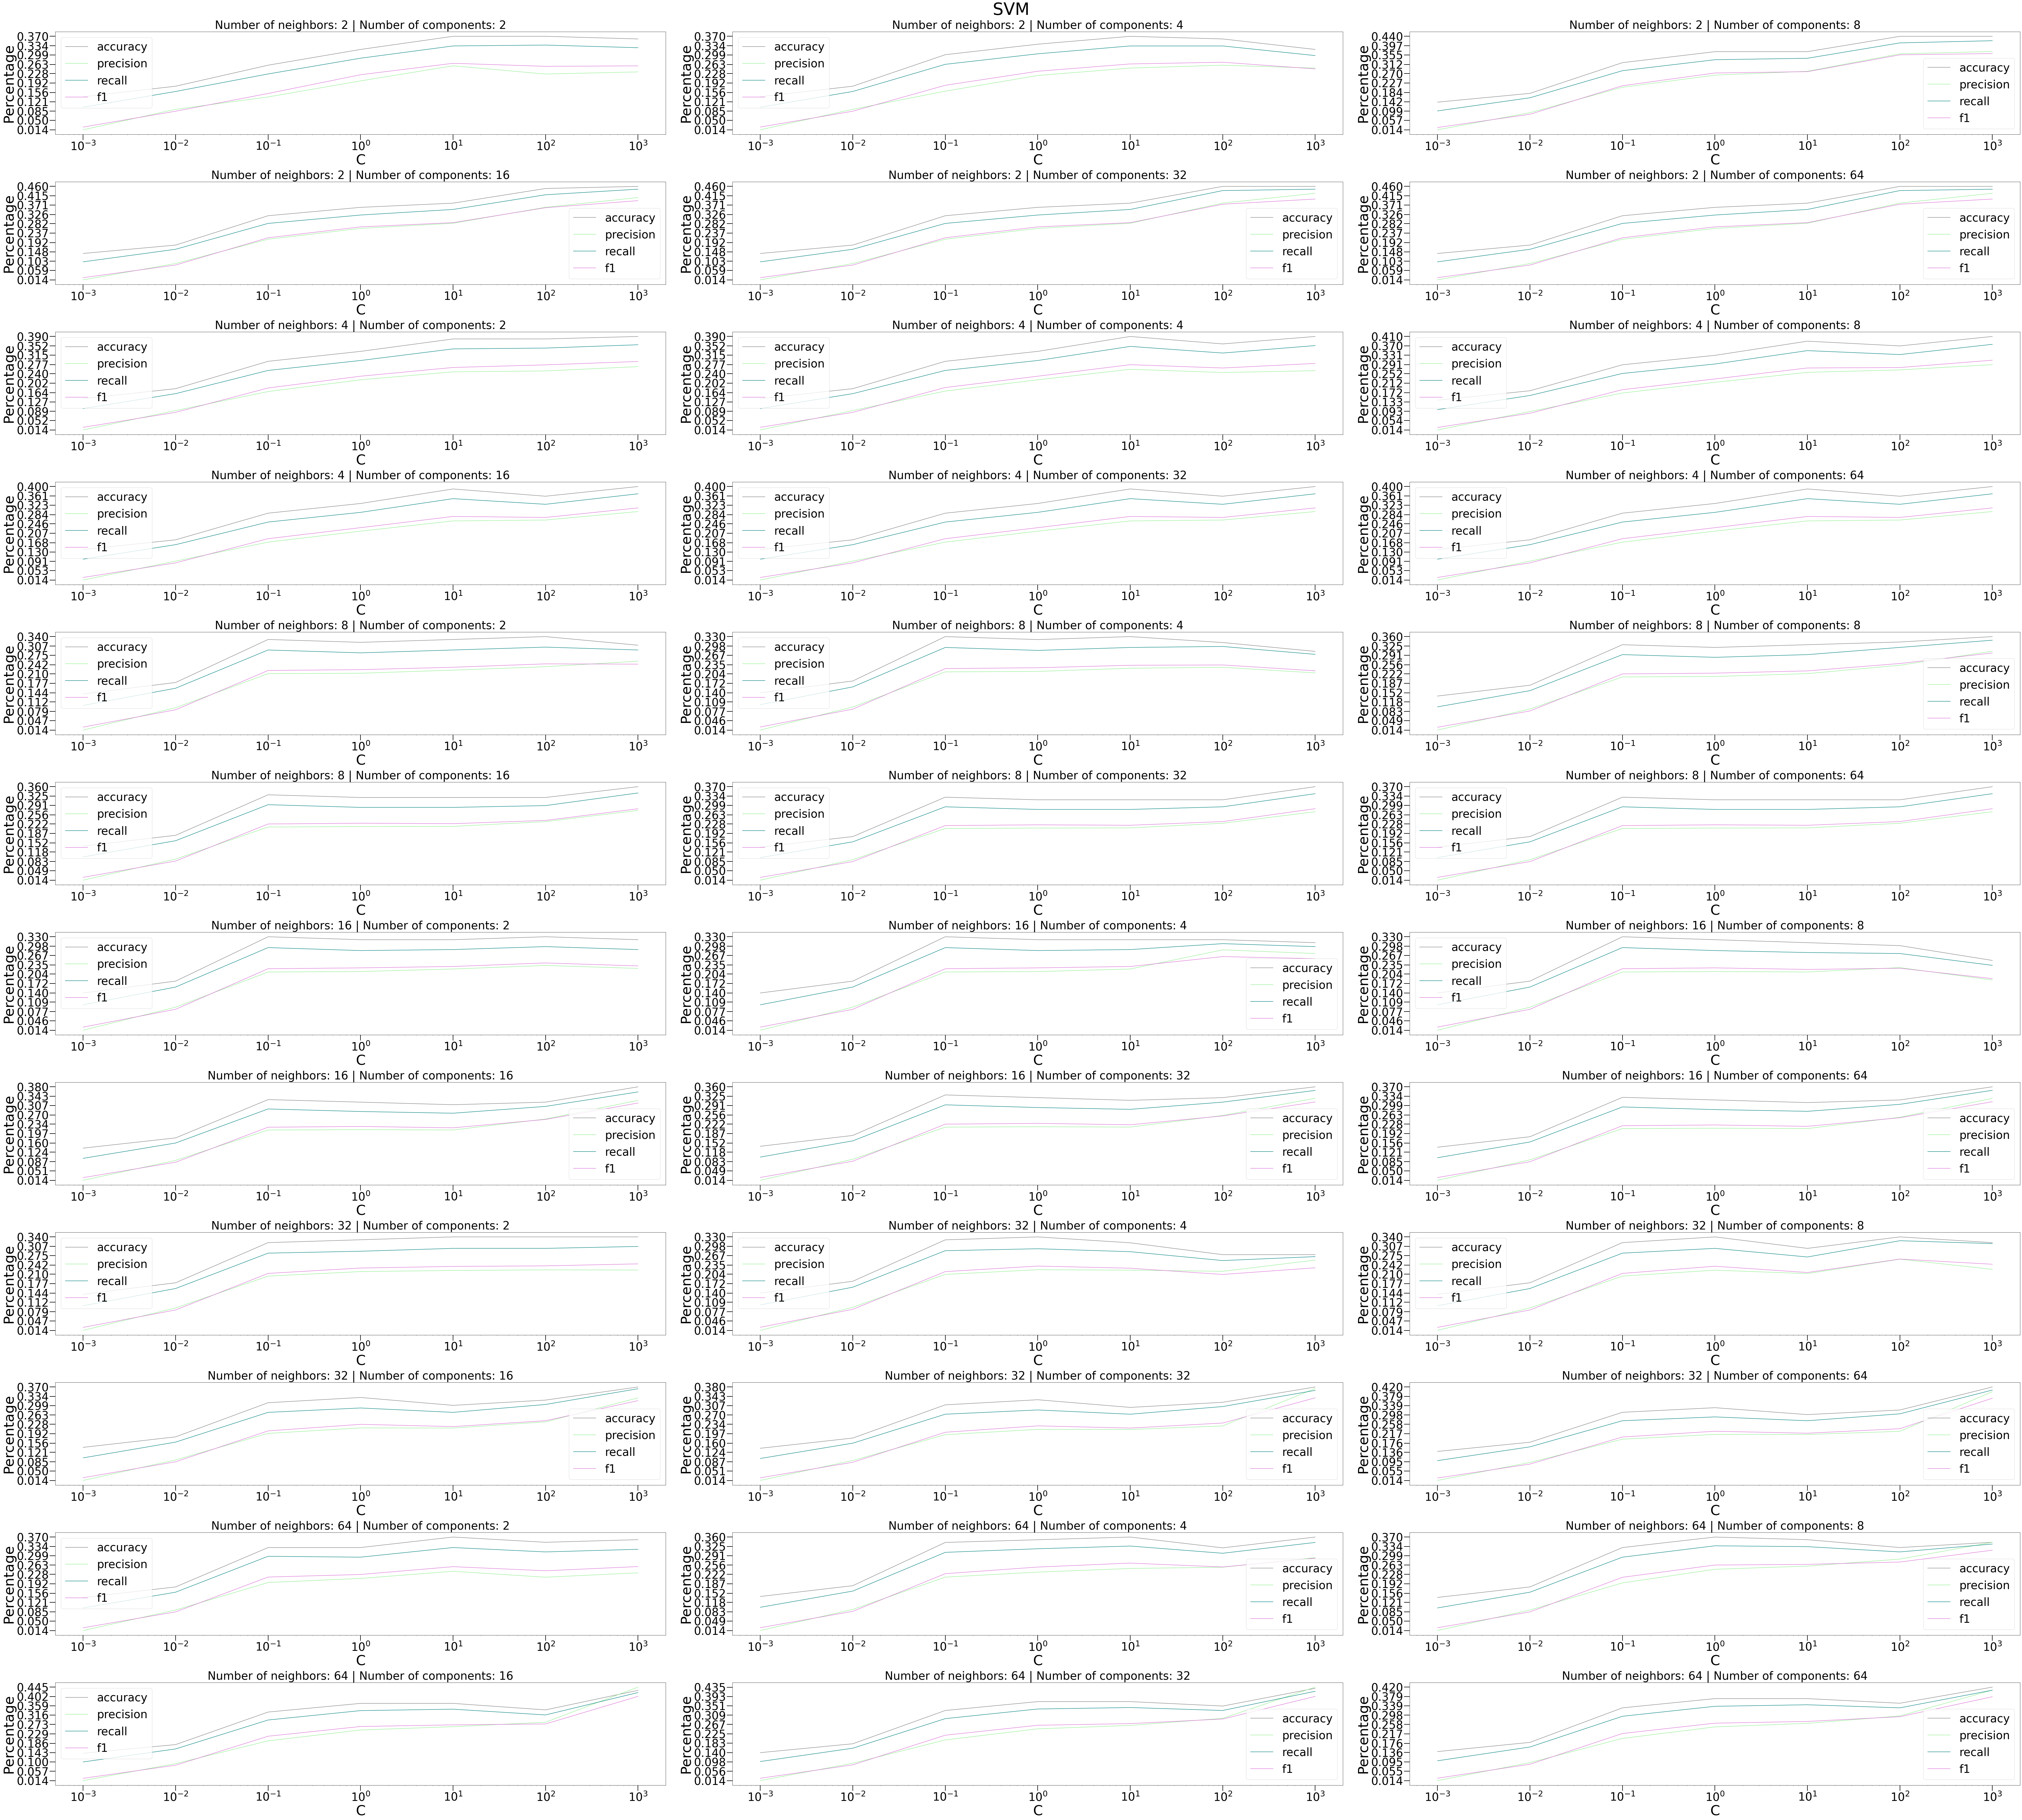

In [17]:
X, Y = extract_dataset("SHOCK")
X = shortest_path_kernel(X)
find_right_svm_manifold_multi(X, Y)

<a id="2.2.1"/></a>
### 2.2.1 Plot decision boundary

Text(0.5, 0.98, 'SVM decision boundary with Manifold')

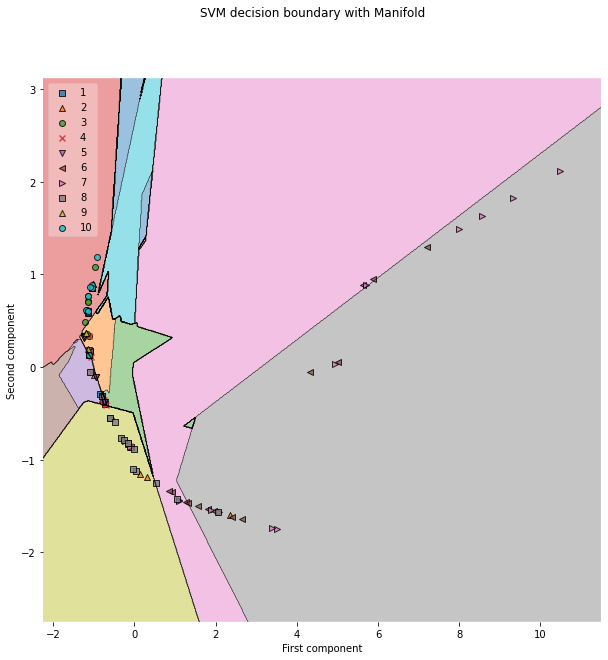

In [15]:
X, y = extract_dataset("SHOCK")
# executing matrix of similarity
X = shortest_path_kernel(X)
# apply Manifold
X = Isomap(n_components=16, n_neighbors=2).fit_transform(X)
# Training a classifier
svm = SVC(kernel='linear', C=10, decision_function_shape='ovo')
svm.fit(X, y)
# create plot
f, ax = plt.subplots(1, 1, figsize = (10, 10))
# it indicates in that point the other (those not displayed) coordinates must be held fixed
value = 0
# it indicates how many these coordinates can move
width = 1
# Plotting decision regions
plot_decision_regions(X, y, clf=svm, legend=2, ax=ax, 
                        filler_feature_values={i:value for i in range(2, 16)},
                        filler_feature_ranges={i:width for i in range(2, 16)})
# change name axes
ax.set_ylabel("Second component")
ax.set_xlabel("First component")
# insert title
f.suptitle('SVM decision boundary with Manifold')

<a id="2.2.2"/></a>
### 2.2.2 Plot for Report

In [18]:
# create the plot for report
def plotting_for_report(X, Y, emphasy = 1, kernel="linear"):
    # vector to plot
    v_precision=[]; v_recall=[]; v_f1=[]; v_accuracy=[]
    # C is a hypermeter in SVM to control error
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    # parameter to determine the number of neighbors for the manifold
    N_neighbors_manifold = [2, 4, 8, 16, 32, 64]
    # parameter to determine the number of components that manifold must hold
    N_components_manifold = [2, 4, 8, 16, 32, 64]
    for n_neig in N_neighbors_manifold:
        # vector to plot for neighbors
        tmp_N_v_precision=[]; tmp_N_v_recall=[]; tmp_N_v_f1=[]; tmp_N_v_accuracy=[]
        for n_com in N_components_manifold:
            # vector to plot for components
            tmp_C_v_precision=[]; tmp_C_v_recall=[]; tmp_C_v_f1=[]; tmp_C_v_accuracy=[]
            # create manifold and transform data
            X_tr = Isomap(n_components=n_com, n_neighbors=n_neig).fit_transform(X)
            # split train set in train and validation
            x_train, x_test, y_train, y_test = train_test_split(X_tr, Y, test_size=0.33, random_state=42)
            for c in C:
                # create instance of classificator
                svm_tmp = SVC(kernel=kernel, C=c)
                # make a custom scorer for a measure (more enphasy about precision)
                ftwo_scorer = make_scorer(fbeta_score, beta=emphasy, average='macro')
                ftwo_precision = make_scorer(precision_score, zero_division = 0, average='macro')
                # various measures for each distance that they are inserted inside a list for hyperparam C
                tmp_C_v_accuracy.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1).mean())
                tmp_C_v_precision.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_precision, n_jobs=-1).mean())
                tmp_C_v_recall.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring='recall', n_jobs=-1).mean())
                tmp_C_v_f1.append(cross_val_score(svm_tmp, x_train, y_train, cv=10, scoring=ftwo_scorer, n_jobs=-1).mean())
            # insert inside the external list that I need to plot in a right way for hyperparam n_components
            tmp_N_v_precision.append(tmp_C_v_precision)
            tmp_N_v_recall.append(tmp_C_v_recall)
            tmp_N_v_f1.append(tmp_C_v_f1)
            tmp_N_v_accuracy.append(tmp_C_v_accuracy)
        # insert inside the external list that I need to plot in a right way for hyperparam n_neighborns
        v_precision.append(tmp_N_v_precision)
        v_recall.append(tmp_N_v_recall)
        v_f1.append(tmp_N_v_f1)
        v_accuracy.append(tmp_N_v_accuracy)
    l_b = best_for_plot(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1)
    print_graph_for_report(l_b, N_neighbors_manifold, N_components_manifold)



# find the best hyperparameters for each neigh and comp
def best_for_plot(C, N_neighbors_manifold, N_components_manifold, v_accuracy, v_f1):
    # holds the best performance with the hyperparameters to find it
    list_of_best = []
    for neigh, (neigh_l_a, neigh_l_f) in enumerate(zip(v_accuracy, v_f1)):
        for comp, (comp_l_a, comp_l_f) in enumerate(zip(neigh_l_a, neigh_l_f)):
            # compute the mean to find the best hyperparameter C for a specific n_components and n_neighborns
            tmp_sum = [(x + y)/2 for x, y in zip(comp_l_a, comp_l_f)]
            # tupla with              (best value, hyperparameter C, hyperparameter n_components, hyperparameter n_neighborn)
            list_of_best.append((np.max(tmp_sum), C[np.argmax(tmp_sum)], N_components_manifold[comp], N_neighbors_manifold[neigh]))
    return list_of_best


# print graph for report
def print_graph_for_report(l_b, N_neighbors_manifold, N_components_manifold):
    # sort by components
    sort_by_comp = sorted(l_b, key=lambda item: item[2])
    # sort by neighborns
    sort_by_neig = sorted(l_b, key=lambda item: item[3])
    # lists for graphs
    l_print_comp, l_print_neig = [], []
    # CREATE LIST FOR PLOT FOR COMPONENTS
    # iterator for move the list of N_neighbors_manifold and N_components_manifold to find the list for plot
    it = 0
    # holds the max value
    maxi = 0
    for t_comp in sort_by_comp:
        if t_comp[2] != N_components_manifold[it]:
            # change component
            it+=1
            l_print_comp.append(maxi)
            # restart maxi
            maxi = 0
        if t_comp[0] > maxi:
            maxi = t_comp[0]
    l_print_comp.append(maxi)
    # CREATE LIST FOR PLOT FOR NEIGHBORNS
    # iterator for move the list of N_neighbors_manifold and N_components_manifold to find the list for plot
    it = 0
    # holds the max value
    maxi = 0
    # create list for plot for components
    for t_neig in sort_by_neig:
        if t_neig[3] != N_neighbors_manifold[it]:
            # change component
            it+=1
            l_print_neig.append(maxi)
            # restart maxi
            maxi = 0
        if t_neig[0] > maxi:
            maxi = t_neig[0]
    l_print_neig.append(maxi)
    # create graphs
    fig, axs = plt.subplots(1, 2, figsize=(20,10), constrained_layout = True)  
    for ax, plot in zip(axs, [(N_components_manifold,l_print_comp, "orchid", "n_components"), (N_neighbors_manifold,l_print_neig, "teal", "n_neighbors")]):
        ax.plot(plot[0], plot[1], color=plot[2], linewidth=5)
        ax.set_ylabel("mean between accuracy and f1-score", fontsize = 15)
        ax.set_xlabel(plot[3], fontsize = 15)
        ax.set_xscale('log', base=2)
        ax.set_yticks(plot[1])
        ax.tick_params('both', length=20, width=2, which='major', labelsize=10)
        
    
    
    

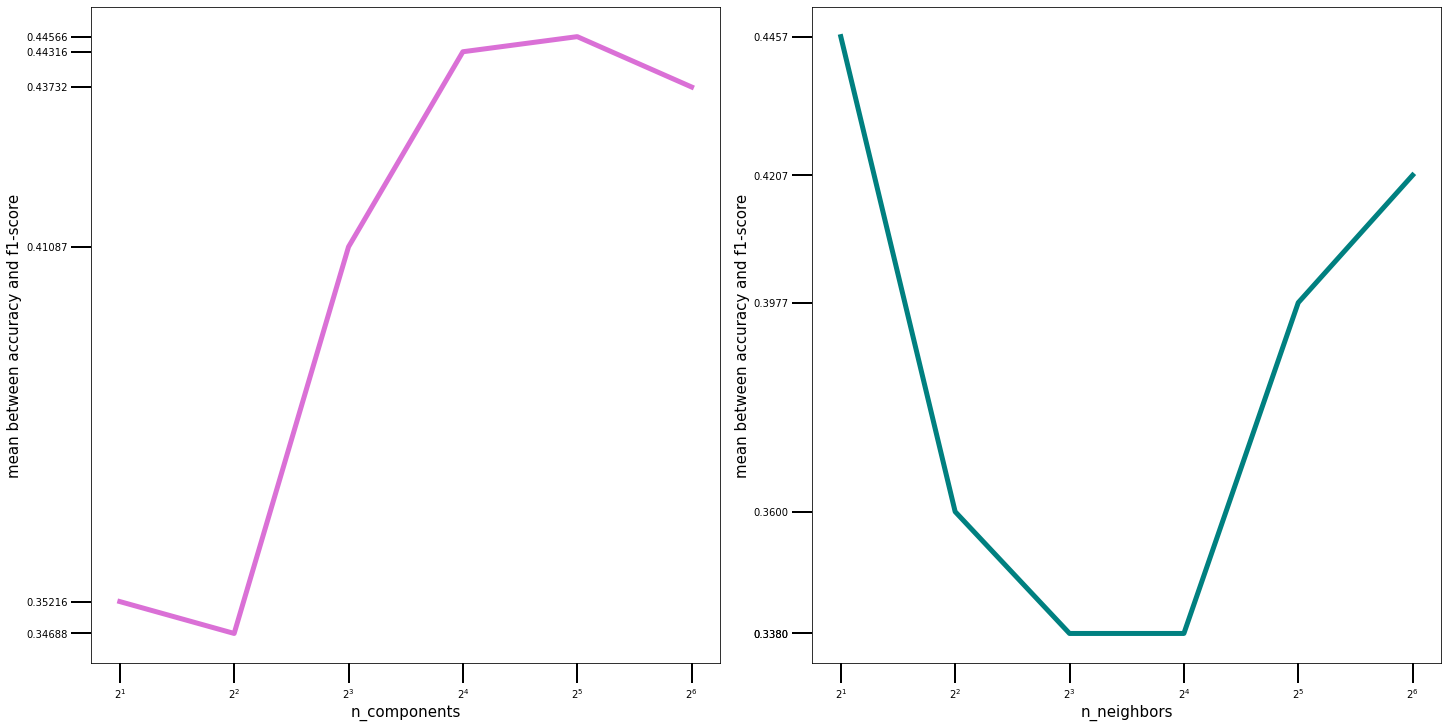

In [19]:
X, Y = extract_dataset("SHOCK")
# compute the similarity matrix
X = shortest_path_kernel(X)
plotting_for_report(X, Y)